In [94]:
#テンプレート

# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.model_selection import KFold  # 通常のK分割交差検証（今回使用）
from lightgbm import LGBMClassifier  # LightGBMのモデルクラス


# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '../data/'


X = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

# 欠損値の確認

In [95]:
train.isnull().sum()

Id                  0
Year                0
School              0
Height              0
Weight              0
Sprint_40yd         0
Vertical_Jump       0
Bench_Press_Reps    0
Broad_Jump          0
Agility_3cone       0
Shuttle             0
Player_Type         0
Position_Type       0
Position            0
Drafted             0
Age_missing         0
Age_filled          0
dtype: int64

In [96]:
test.isnull().sum()

Id                    0
Year                  0
Age                 115
School                0
Height                0
Weight                0
Sprint_40yd          29
Vertical_Jump       143
Bench_Press_Reps    184
Broad_Jump          147
Agility_3cone       247
Shuttle             228
Player_Type           0
Position_Type         0
Position              0
dtype: int64

# Ageに対するEDA

In [97]:
# Ageが欠損しているかどうかの列を作成
X["Age_missing"] = X["Age"].isna()

# 欠損の有無ごとのドラフト率を集計
draft_rate_by_age_missing = X.groupby("Age_missing")["Drafted"].mean()

print(draft_rate_by_age_missing)


Age_missing
False    0.765132
True     0.018391
Name: Drafted, dtype: float64


### 年齢欠損とドラフト率の関係分析

`Age` 列の欠損状況を示すフラグ `Age_missing` を作成し、それによってドラフト率にどのような差があるかを確認した。

結果、`Age_missing = False`（= 年齢が記録されている選手）のドラフト率は **76.5%** であったのに対し、  
`Age_missing = True`（= 年齢が欠損している選手）のドラフト率は **1.8%** にとどまった。

この大きな差から、**年齢情報の有無がドラフトされるかどうかに強く関係している**ことが分かる。  
特に、年齢が欠損している選手は、ほとんどドラフトされていない傾向が見られた。

したがって `Age_missing` という欠損フラグは、モデルにとって非常に有用な特徴量となる可能性が高い。

# 欠損値の処理
本データには、`Age` や身体能力テストに関連する複数の数値項目に欠損値が含まれていたため、以下の方針で欠損値処理を行った。

#### 1. `Age` 列の処理

`Age` は、欠損の有無がドラフト率に強く影響していたことから、以下の2つの特徴量に分解し、元の `Age` 列は削除した：

- `Age_filled`：`Age` の欠損値を `-1` で補完（年齢としてありえない値で補うことで欠損を明示）
- `Age_missing`：`Age` が欠損していたかどうかを示すフラグ（0 or 1）

この2軸に分けることで、年齢の情報と欠損の有無の両方をモデルに渡せるようにした。

In [98]:
# Ageの欠損補完と欠損フラグの追加（trainとtestの両方に適用）

# Xデータ
X["Age_filled"] = X["Age"].fillna(-1)
X["Age_missing"] = X["Age"].isna().astype(int)
X = X.drop(columns=["Age"])

# testデータ
test["Age_filled"] = test["Age"].fillna(-1)
test["Age_missing"] = test["Age"].isna().astype(int)
test = test.drop(columns=["Age"])


#### 2. その他の数値項目の処理

`Sprint_40yd`, `Vertical_Jump`, `Bench_Press_Reps` など、身体能力に関する指標の多くに欠損が存在していた。

これらは、明確な外れ値や分布の歪みがない限り、**中央値（`median`）で補完**することにした。中央値を用いることで、外れ値の影響を受けにくく、ロバストな処理が可能になる。


In [99]:
# 数値項目のうち欠損があるものを中央値で補完（X/test共通処理）

# 欠損がある列を自動検出して処理
for col in X.columns:
    if X[col].isna().sum() > 0:
        median = X[col].median()
        X[col] = X[col].fillna(median)
        test[col] = test[col].fillna(median)



#### 3. LightGBMとの整合性

LightGBMは欠損値を内部的に処理する能力を持っているが、今回のように欠損が比較的多く、かつ意味のある傾向が見られる場合は、補完処理＋欠損フラグの併用が有効と判断した。

また、補完後はすべての数値項目をモデルに直接渡すことができる状態となった。

### モデル学習前のデータ加工

LightGBM による学習を行う前に、データ形式を整える必要がある。特に、LightGBM は `int`, `float`, `bool` 型の数値データを前提とするため、`object` 型（文字列）のカテゴリ変数は数値化が必要である。

#### 0. 不要な列の削除

`Id` 列は選手を識別するための単なる識別子であり、モデルの学習には不要である。  
数値であるためLightGBMにとっては有効な特徴量に見えてしまうが、実際には意味のない情報をモデルに与えることになってしまうため、**学習前に必ず削除する必要がある**。

In [100]:
X = X.drop(columns=["Id"])
test = test.drop(columns=["Id"])

#### 1. カテゴリ変数のラベルエンコーディング

以下の4列は文字列型のカテゴリ変数であり、そのままではLightGBMで扱えないため、`LabelEncoder` を用いて数値に変換する：

- `School`
- `Player_Type`
- `Position_Type`
- `Position`

In [101]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["School", "Player_Type", "Position_Type", "Position"]

for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([X[col], test[col]]).astype(str)
    le.fit(all_values)
    
    X[col] = le.transform(X[col].astype(str))
    test[col] = le.transform(test[col].astype(str))



In [102]:
print(X.dtypes)



Year                  int64
School                int64
Height              float64
Weight              float64
Sprint_40yd         float64
Vertical_Jump       float64
Bench_Press_Reps    float64
Broad_Jump          float64
Agility_3cone       float64
Shuttle             float64
Player_Type           int64
Position_Type         int64
Position              int64
Drafted             float64
Age_missing           int64
Age_filled          float64
dtype: object


In [103]:
X = X.drop(columns=["Drafted"])
y = train["Drafted"]


In [104]:
print(X.dtypes[X.dtypes == "object"])


Series([], dtype: object)


In [105]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = LGBMClassifier(
    max_depth=3,           # 木の深さを浅く
    num_leaves=7,          # 葉の数を少なく（2^3 - 1 = 7）
    min_child_samples=30,  # 葉に必要な最小データ数を増やす
    learning_rate=0.05,    # 学習率を下げる
    n_estimators=500,      # 木の本数は多めに（学習率を下げた分）
    reg_alpha=1.0,         # L1正則化
    reg_lambda=1.0,        # L2正則化
    random_state=42
)

    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc'
)


    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\nAverage Train AUC: {np.mean(train_aucs):.4f}")
print(f"Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

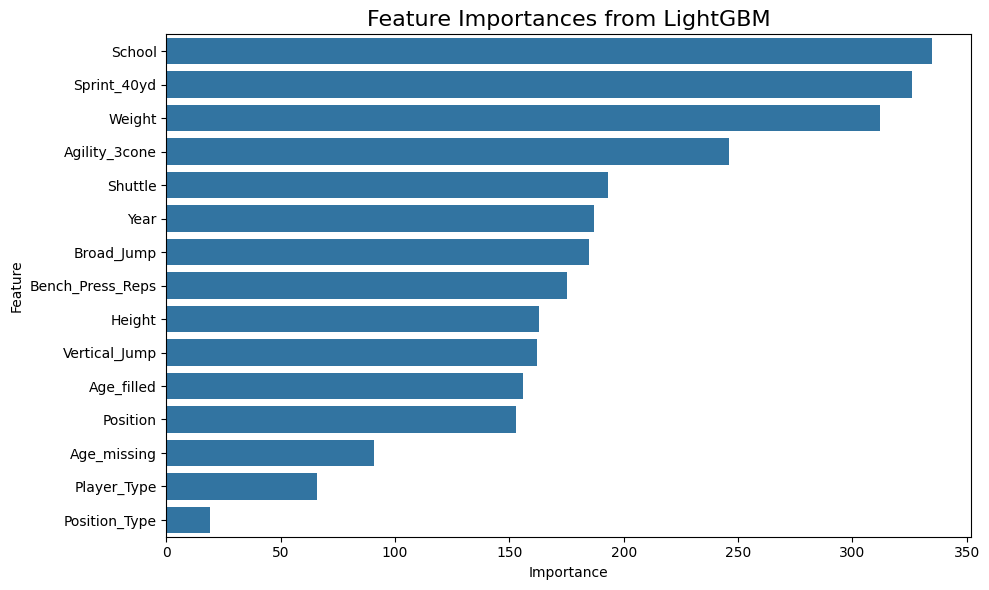

In [106]:
# 特徴量とその重要度をDataFrameにまとめる
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances from LightGBM', fontsize=16)  # タイトルを修正
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


過学習なので、BMIを追加

In [107]:
X["BMI"] = X["Weight"] / (X["Height"] / 100) ** 2
test["BMI"] = test["Weight"] / (test["Height"] / 100) ** 2


In [108]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = LGBMClassifier(
    max_depth=3,
    num_leaves=7,
    min_child_samples=30,
    min_split_gain=0.1,         # 追加1
    subsample=0.8,              # 追加2
    colsample_bytree=0.8,       # 追加3
    reg_alpha=2.0,              # 強化1
    reg_lambda=2.0,             # 強化2
    learning_rate=0.05,
    n_estimators=500,
    random_state=42
)


    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc'
)


    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\nAverage Train AUC: {np.mean(train_aucs):.4f}")
print(f"Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1171
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

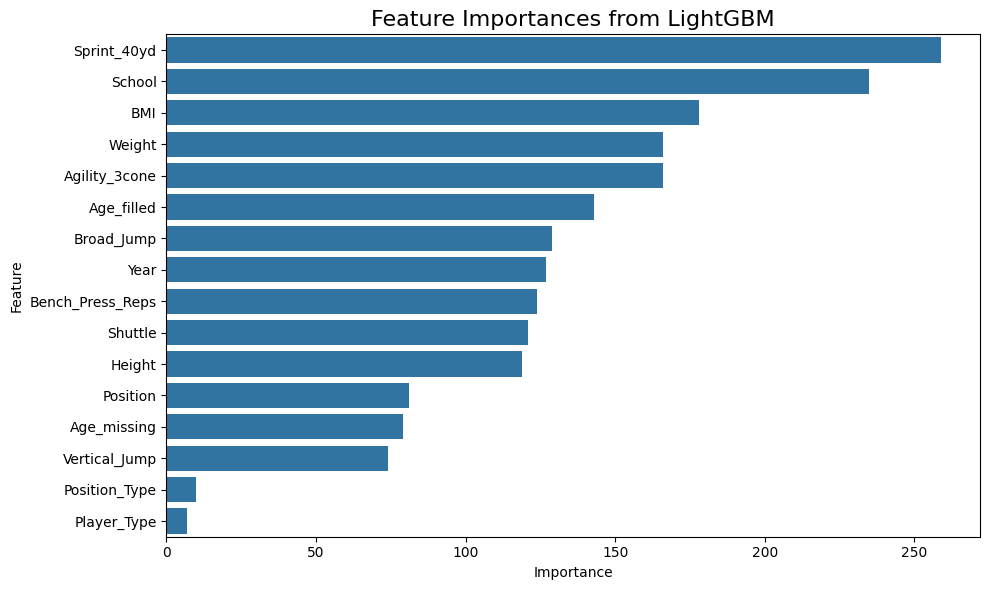

In [109]:
# 特徴量とその重要度をDataFrameにまとめる
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances from LightGBM', fontsize=16)  # タイトルを修正
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# schoolを削除

In [110]:
X = X.drop(columns=["School"])
test = test.drop(columns=["School"])


In [111]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    model = LGBMClassifier(
    max_depth=3,
    num_leaves=7,
    min_child_samples=30,
    min_split_gain=0.1,         # 追加1
    subsample=0.8,              # 追加2
    colsample_bytree=0.8,       # 追加3
    reg_alpha=2.0,              # 強化1
    reg_lambda=2.0,             # 強化2
    learning_rate=0.05,
    n_estimators=500,
    random_state=42
)


    model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc'
)


    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

print(f"\nAverage Train AUC: {np.mean(train_aucs):.4f}")
print(f"Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

# 結果
Average Train AUC: 0.9166
Average Validation AUC: 0.8254

少しずつ改善してきてはいるが、まだAUC差は大きいので、提出はできない。

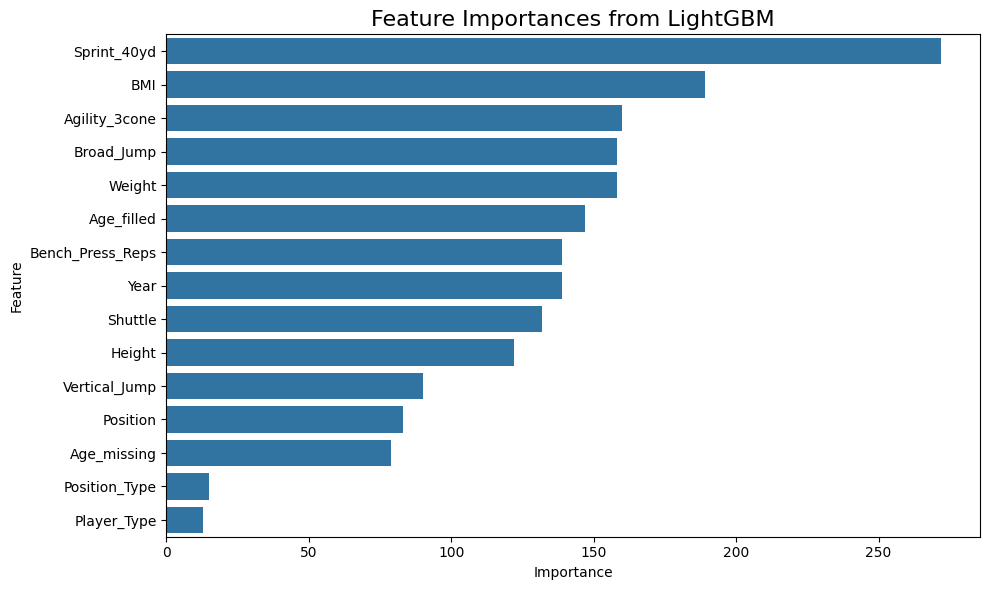

In [112]:
# 特徴量とその重要度をDataFrameにまとめる
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances from LightGBM', fontsize=16)  # タイトルを修正
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [115]:
X_temp = X.copy()
X_temp["Drafted"] = y

player_type_map = X_temp.groupby("Player_Type")["Drafted"].mean()
X["Player_Type_te"] = X["Player_Type"].map(player_type_map)
test["Player_Type_te"] = test["Player_Type"].map(player_type_map)  # ← test にも適用
